# LIME & SHAP with a Pretrained Model on CIFAR-10

# 0) Setup & Imports

In [1]:
!pip -q install shap lime scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.applications import (
resnet50, # ResNet50 application module
inception_v3 # InceptionV3 application module
)
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet, decode_predictions as decode_resnet
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_inception, decode_predictions as decode_inception

from tensorflow.keras.datasets import cifar10

from lime import lime_image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

import shap

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 1) Config: Choose model ("resnet50" or "inceptionv3")

In [3]:
# =========================
MODEL_NAME = "resnet50" # Change to "inceptionv3" if you prefer that backbone


if MODEL_NAME.lower() == "resnet50":
  input_size = (224, 224) # ResNet50 expected input HxW
  model = ResNet50(weights="imagenet") # Load ImageNet weights
  preprocess_fn = preprocess_resnet # Model-specific preprocessing
  decode_fn = decode_resnet # Model-specific decode_predictions
elif MODEL_NAME.lower() == "inceptionv3":
  input_size = (299, 299) # InceptionV3 expected input HxW
  model = InceptionV3(weights="imagenet") # Load ImageNet weights
  preprocess_fn = preprocess_inception # Model-specific preprocessing
  decode_fn = decode_inception # Model-specific decode_predictions
else:
  raise ValueError("MODEL_NAME must be 'resnet50' or 'inceptionv3'.")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# 2) Load CIFAR-10 and pick 5 test images

In [4]:
# CIFAR-10 images are (32, 32, 3), uint8 in [0, 255].
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Choose 5 random indices from the test set (reproducibly)
rng = np.random.default_rng(RANDOM_STATE)
idx5 = rng.choice(np.arange(len(x_test)), size=5, replace=False)
X5_raw = x_test[idx5] # Shape (5, 32, 32, 3), uint8
print("Chosen CIFAR-10 test indices:", idx5.tolist())

# CIFAR-10 class names (for reference only; model predicts ImageNet classes)
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print("Ground-truth CIFAR-10 labels:", [cifar10_labels[int(y_test[i])] for i in idx5])

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Chosen CIFAR-10 test indices: [7737, 4388, 6544, 892, 4330]
Ground-truth CIFAR-10 labels: ['airplane', 'bird', 'airplane', 'horse', 'truck']


# 3) Preprocess for the chosen model and predict

In [5]:
# Helper: resize and preprocess a batch of RGB images to the model's expected shape
def preprocess_batch(images_rgb_uint8):
  # Convert to float32 and resize to model's input_size, then apply preprocess_input
  images_f32 = tf.image.resize(tf.cast(images_rgb_uint8, tf.float32), input_size).numpy()
  return preprocess_fn(images_f32) # Model-specific preprocessing (handles scaling/centering)

# Prepare the batch and get predictions
X5_pre = preprocess_batch(X5_raw)
probs = model.predict(X5_pre, verbose=0) # Predict ImageNet softmax (shape: 5 x 1000)

# Decode top-3 predictions for each image for inspection
for i in range(5):
  top3 = decode_fn(probs[i:i+1], top=3)[0]
  print(f"\nImage idx {int(idx5[i])} (CIFAR-10: {cifar10_labels[int(y_test[idx5[i]])]}):")
  for (wnid, label, score) in top3:
    print(f" {label:25s} p={score:.3f}")

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Image idx 7737 (CIFAR-10: airplane):
 bobsled                   p=0.080
 loupe                     p=0.077
 airliner                  p=0.043

Image idx 4388 (CIFAR-10: bird):
 power_drill               p=0.093
 nail                      p=0.083
 plunger                   p=0.076

Image idx 6544 (CIFAR-10: airplane):
 container_ship            p=0.266
 thresher                  p=0.190
 steel_arch_bridge         p=0.082

Image idx 892 (CIFAR-10: horse):
 curly-coated_retriever    p=0.240
 coyote                    p=0.194
 Scottish_deerhound        p=0.140

Image idx 4330 (CIFAR-10: truck):
 moving_van                p=1.000
 trailer_truck             p=0.000
 garbage_truck             p=0.000


# 4) LIME Explanations (superpixel-based)

  0%|          | 0/1000 [00:00<?, ?it/s]

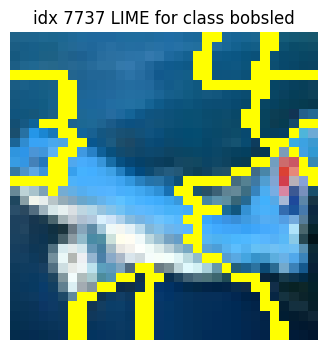

  0%|          | 0/1000 [00:00<?, ?it/s]

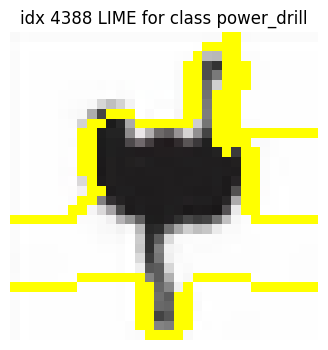

  0%|          | 0/1000 [00:00<?, ?it/s]

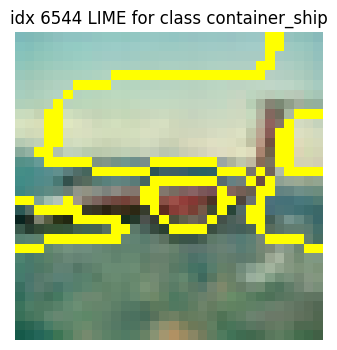

  0%|          | 0/1000 [00:00<?, ?it/s]

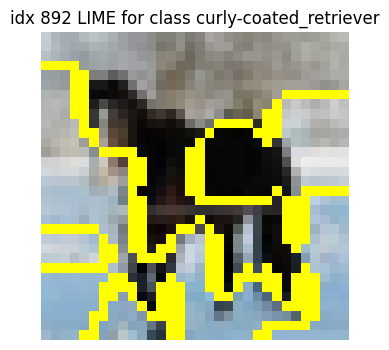

  0%|          | 0/1000 [00:00<?, ?it/s]

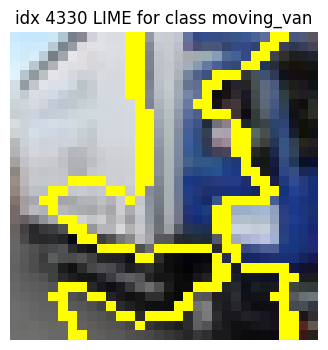

In [6]:
# Segmentation function using SLIC superpixels (tweak n_segments for finer/coarser patches)
segmentation_fn = lambda img: slic(img, n_segments=50, compactness=10, sigma=1, start_label=0)


lime_explainer = lime_image.LimeImageExplainer()


# Classifier function wrapper for LIME (expects images as RGB float arrays)
def classifier_fn_lime(batch_rgb):
  # Ensure numpy array
  arr = np.array(batch_rgb)
  # If input is [0,1] scale, bring to [0,255] range (LIME may provide floats)
  if arr.max() <= 1.0:
    arr = arr * 255.0
  # Preprocess for the selected model
  arr_pre = preprocess_batch(arr)
  # Keras model predicts probabilities over 1000 ImageNet classes
  return model.predict(arr_pre, verbose=0)


# Helper to visualize LIME positive regions for the top predicted class
def show_lime_for_image(rgb_uint8, explanation, class_id, title_prefix=""):
  temp, mask = explanation.get_image_and_mask(label=class_id, positive_only=True,
                                              hide_rest=False, num_features=10, min_weight=0.0)
  plt.figure(figsize=(4,4))
  plt.imshow(mark_boundaries(temp.astype(np.uint8), mask))
  # Fix: Provide a valid numpy array to decode_fn
  # Create a dummy prediction array with a high probability for the target class
  dummy_preds = np.zeros((1, 1000))
  dummy_preds[0, class_id] = 1.0
  plt.title(f"{title_prefix} LIME for class {decode_fn(dummy_preds)[0][0][1]}")
  plt.axis('off')
  plt.show()


lime_explanations = []
for i in range(5):
  # LIME works best with RGB uint8 images
  img_rgb = X5_raw[i]
  # Determine top predicted class index from model's probs
  top_class = int(np.argmax(probs[i]))
  # Explain instance with LIME; top_labels=1 restricts to the most probable class
  exp = lime_explainer.explain_instance(
      image=img_rgb,
      classifier_fn=classifier_fn_lime,
      top_labels=1,
      hide_color=0,
      num_samples=1000,
      segmentation_fn=segmentation_fn
  )
  lime_explanations.append(exp)
  show_lime_for_image(img_rgb, exp, top_class, title_prefix=f"idx {int(idx5[i])}")

# 5) SHAP Explanations (GradientExplainer)

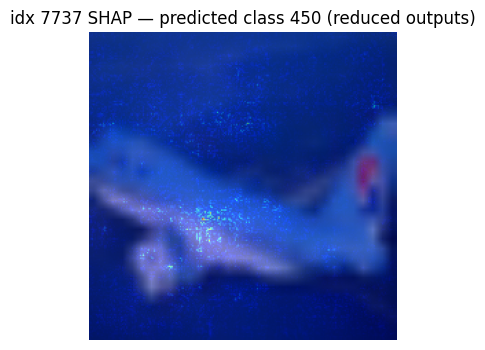

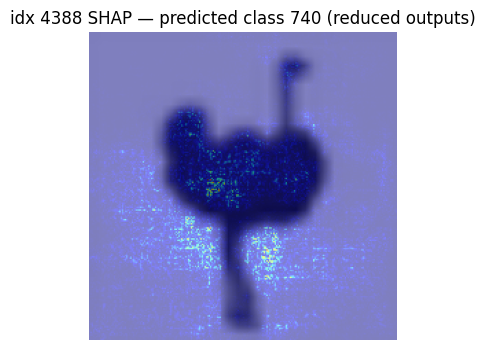

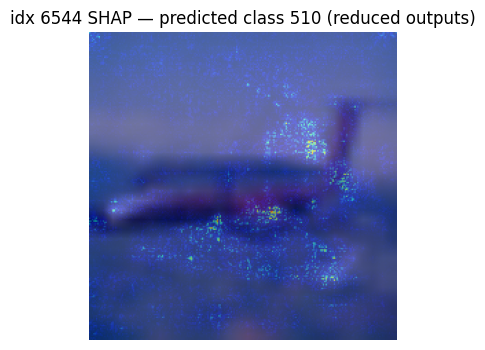

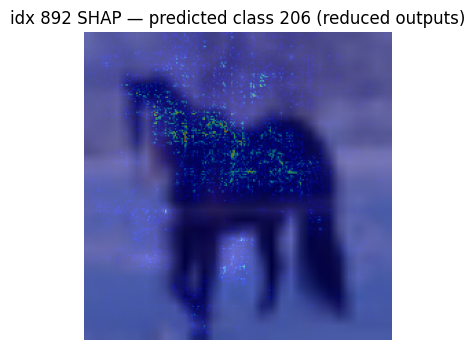

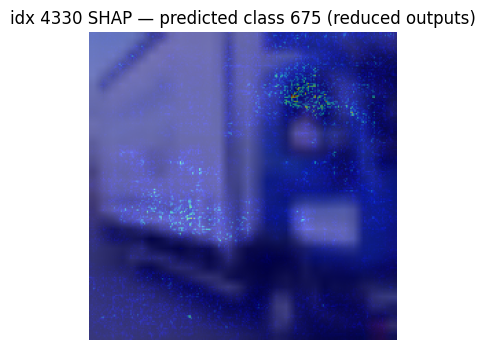

In [10]:
# === FAST SHAP: reduce outputs to only the predicted classes for our 5 images ===
# 1) Keep tiny background for speed (you already did this)
bg_idx = rng.choice(np.arange(len(x_train)), size=1, replace=False)  # 1 background image
background_raw = x_train[bg_idx]                                     # (1, 32, 32, 3) uint8
background_pre = preprocess_batch(background_raw)                    # resize + preprocess for the backbone

# 2) Find the predicted class for each of the 5 images, then deduplicate to minimize outputs
pred_classes_5 = np.argmax(probs, axis=1)            # length 5, ImageNet class ids [0..999]
unique_pred_classes = np.unique(pred_classes_5)      # typically 3–5 classes at most

# 3) Build a "reduced-output" model that only returns those columns from the softmax
#    This drastically reduces the gradient work SHAP must do (vs. full 1000-class head).
import tensorflow as tf
from tensorflow.keras import layers, Model

# Gather the selected columns from the softmax output
gather_layer = layers.Lambda(lambda x: tf.gather(x, unique_pred_classes, axis=1), name="gather_selected_outputs")
reduced_outputs = gather_layer(model.output)
reduced_model = Model(inputs=model.inputs, outputs=reduced_outputs)

# 4) Create a GradientExplainer on the reduced-output model
explainer = shap.GradientExplainer(reduced_model, background_pre)

# 5) Compute SHAP values for our 5 preprocessed images (now only for a handful of outputs)
#    Depending on SHAP version, this may return a list (per output) or a single array.
shap_values_reduced = explainer.shap_values(X5_pre)

# 6) For visualization, build a map from each image's predicted class -> index in the reduced head
class_to_reduced_idx = {int(c): i for i, c in enumerate(unique_pred_classes)}

# For consistent background in plots (only affects display, not SHAP math)
X5_vis = tf.image.resize(tf.cast(X5_raw, tf.float32), input_size).numpy().astype(np.uint8)

# 7) Helper: show SHAP heatmap overlay for each image's predicted class (from the reduced outputs)
def show_shap_for_pred_fast(idx_in_batch):
    pred_class = int(pred_classes_5[idx_in_batch])
    red_idx = class_to_reduced_idx[pred_class]  # which column of reduced head corresponds to this image's class

    # Handle SHAP return types: list (per-output) or array
    if isinstance(shap_values_reduced, list):
        sv = shap_values_reduced[red_idx][idx_in_batch]  # (H, W, C)
    else:
        # shape could be (N, H, W, C, num_outputs) or similar; try to index last dim
        sv_raw = shap_values_reduced[idx_in_batch]
        sv = sv_raw[..., red_idx] if sv_raw.ndim >= 4 else sv_raw

    # Reduce channels to a single map via mean |contribution| per pixel
    sv_map = np.mean(np.abs(sv), axis=-1) if sv.ndim == 3 else np.abs(sv).squeeze()

    plt.figure(figsize=(4,4))
    plt.imshow(X5_vis[idx_in_batch])
    plt.imshow(sv_map, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"idx {int(idx5[idx_in_batch])} SHAP — predicted class {pred_class} (reduced outputs)")
    plt.show()

# 8) Plot the 5 explanations quickly
for i in range(5):
    show_shap_for_pred_fast(i)
